In [1]:
import tensorflow as tf
# tf.config.experimental_run_functions_eagerly(True)
# tf.config.run_functions_eagerly(True)
from PIL import Image
import numpy as np
from utils import *
import matplotlib.pyplot as plt
import os, random

In [2]:
# # Forbidden GPUs
# os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

# set gpus memory used by growth
gpus = tf.config.experimental.list_physical_devices(device_type='GPU')
print("find gpus:",gpus)
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

find gpus: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
batch = 10
ind = 3
inh = 180
inw = 390
inc = 3
upscale = 2

In [4]:
class MySR(tf.keras.models.Model):
    def __init__(self,upscale):
        # 调用父类__init__()方法
        super(MySR, self).__init__()
        self.linear_conv = tf.keras.layers.Conv2D(3*upscale*upscale, 3, strides=1, padding='same', activation=None, name="linear_conv")
        self.conv2d_1 = tf.keras.layers.Conv2D(3*upscale*upscale, 5, strides=1, padding='same', activation='tanh', name="feature_extraction_1")
        self.conv2d_2 = tf.keras.layers.Conv2D(3*upscale*upscale, 3, strides=1, padding='same', activation='tanh', name="feature_extraction_2")
        #self.conv2d_3 = tf.keras.layers.Conv2D(3*upscale*upscale, 3, strides=1, padding='same', activation='tanh', name="feature_extraction_3")
        self.conv2d_4 = tf.keras.layers.Conv2D(3*upscale*upscale, 3, strides=1, padding='same', activation='tanh', name="motion_wrap1")
        self.conv2d_5 = tf.keras.layers.Conv2D(3*upscale*upscale, 3, strides=1, padding='same', activation='tanh', name="motion_wrap2")
        self.conv2d_6 = tf.keras.layers.Conv2D(3*upscale*upscale, 3, strides=1, padding='same', activation='tanh', name="motion_wrap3")
        self.conv2d_7 = tf.keras.layers.Conv2D(3*upscale*upscale, 3, strides=1, padding='same', activation='tanh', name="motion_wrap4")
        self.conv2d_8 = tf.keras.layers.Conv2D(3*upscale*upscale, 3, strides=1, padding='same', activation='tanh', name="conv1")
        self.conv2d_9 = tf.keras.layers.Conv2D(3, 3, strides=1, padding='same', activation=None, name="conv2")
        self.r = upscale
        self.shuffle = Shuffle(upscale)
        #print("Model inited.")

    def call(self, inputs):
        inputs = inputs/127.5 - 1
        x1,x2,x3 = tf.split(inputs,3,1)
        x1 = tf.squeeze(x1, axis=1)
        x2 = tf.squeeze(x2, axis=1)
        x3 = tf.squeeze(x3, axis=1) # current frame
        # Linear Feature Extraction
        linear_fea = self.linear_conv(x3)
        # Nonlinear Feature Extraction
        x1 = self.conv2d_1(x1)
        x1 = self.conv2d_2(x1)
        #x1 = self.conv2d_3(x1)
        x2 = self.conv2d_1(x2)
        x2 = self.conv2d_2(x2)
        #x2 = self.conv2d_3(x2)
        x3 = self.conv2d_1(x3)
        x3 = self.conv2d_2(x3)
        #x3 = self.conv2d_3(x3)
        # Motion Wrap
        x2 = self.conv2d_4(x2)
        x2 = self.conv2d_5(x2)
        x1 = self.conv2d_6(x1)
        x1 = self.conv2d_7(x1)
        # Feature Concat
        nonlinear_fea = tf.concat([x1,x2,x3],axis=3)
        nonlinear_fea = self.conv2d_8(nonlinear_fea)
        x = nonlinear_fea + linear_fea
        # Pixel Shuffle
        x = self.shuffle(x)
        x = self.conv2d_9(x)
        x = tf.clip_by_value(x, -1, 1)
        x = 127.5*(x+1)
        return x

In [5]:
mysr = MySR(upscale)
mysr.build(input_shape=(batch,ind,inh,inw,inc))
print(mysr.summary())

Model: "my_sr"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
linear_conv (Conv2D)         multiple                  336       
_________________________________________________________________
feature_extraction_1 (Conv2D multiple                  912       
_________________________________________________________________
feature_extraction_2 (Conv2D multiple                  1308      
_________________________________________________________________
motion_wrap1 (Conv2D)        multiple                  1308      
_________________________________________________________________
motion_wrap2 (Conv2D)        multiple                  1308      
_________________________________________________________________
motion_wrap3 (Conv2D)        multiple                  1308      
_________________________________________________________________
motion_wrap4 (Conv2D)        multiple                  1308  

In [6]:
def Huber(y_true, y_pred, delta=0.1, axis=None):
    abs_error = tf.abs(y_pred - y_true)
    quadratic = tf.minimum(abs_error, delta)
    # The following expression is the same in value as
    # tf.maximum(abs_error - delta, 0), but importantly the gradient for the
    # expression when abs_error == delta is 0 (for tf.maximum it would be 1).
    # This is necessary to avoid doubling the gradient, since there is already a
    # nonzero contribution to the gradient from the quadratic term.
    linear = (abs_error - quadratic)
    losses = 0.5 * quadratic**2 + delta * linear
    return tf.reduce_mean(losses, axis=axis)

In [7]:
mysr.compile(optimizer='adam',
              loss=Huber,
              # loss = 'MAE',
              metrics=['accuracy'])

In [8]:
def generator(inpath, outpath, batch_size=1, his_num=2):
    # read and sort train data from dir
    x_train_lr_list = os.listdir(inpath)
    x_train_lr_list.sort(key=lambda x:int(x[5:-4]))#倒着数第四位'.'为分界线，按照‘.’左边的数字从小到大排序
    x_train_lr_list = [os.path.join(inpath,c) for c in x_train_lr_list]
    y_train_list = os.listdir(outpath)
    y_train_list.sort(key=lambda x:int(x[5:-4]))
    y_train_list = [os.path.join(outpath,c) for c in y_train_list]
    #i = 0
    while True:
        x_train = []
        y_train = []
        for b in range(batch_size):
            rand = random.randint(3,len(y_train_list)-1)
            lr, hr = loadimgs_from_paths(
                x_train_lr_list[rand-his_num-1:rand], y_train_list[rand-1:rand])
            # print(x_train_lr_list[rand-his_num-1:rand], y_train_list[rand-1:rand])
            x_train.append(lr)
            y_train.append(hr)
        x_train = np.array(x_train)
        y_train = np.squeeze(np.array(y_train),axis=1)
        yield np.float32(x_train), np.float32(y_train)

In [9]:
history = mysr.fit(generator("../data/540cut","../data/1080cut",batch),steps_per_epoch=10, epochs=200, verbose=1)

Epoch 1/200
10/10 [==============================] - 1s 130ms/step - loss: 2.9624 - accuracy: 0.6002
Epoch 2/200
10/10 [==============================] - 1s 130ms/step - loss: 1.7364 - accuracy: 0.6929
Epoch 3/200
10/10 [==============================] - 1s 130ms/step - loss: 1.4061 - accuracy: 0.7309
Epoch 4/200
10/10 [==============================] - 1s 131ms/step - loss: 1.1753 - accuracy: 0.7740
Epoch 5/200
10/10 [==============================] - 1s 132ms/step - loss: 1.0319 - accuracy: 0.7894
Epoch 6/200
10/10 [==============================] - 1s 133ms/step - loss: 0.9277 - accuracy: 0.8137
Epoch 7/200
10/10 [==============================] - 1s 128ms/step - loss: 0.8255 - accuracy: 0.8453
Epoch 8/200
10/10 [==============================] - 1s 128ms/step - loss: 0.7735 - accuracy: 0.8485
Epoch 9/200
10/10 [==============================] - 1s 127ms/step - loss: 0.7280 - accuracy: 0.8452
Epoch 10/200
10/10 [==============================] - 1s 127ms/step - loss: 0.6808 - accura

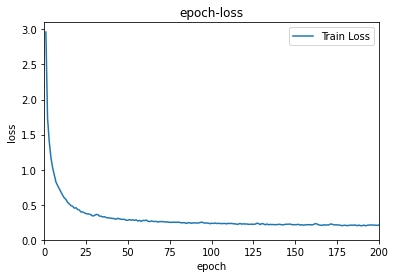

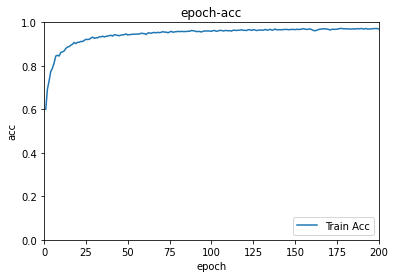

In [10]:
# Visualization
epochs = 200
l = np.array(history.history['loss'])
a = np.array(history.history['accuracy'])
step = np.linspace(1,epochs,epochs)
plt.plot(step,l,label="Train Loss")
plt.legend(loc='upper right')
plt.title('epoch-loss')
plt.xlim((0, epochs))
plt.gca().set_ylim(bottom=0)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.savefig('./train-loss.png', bbox_inches='tight')
plt.show()
plt.plot(step,a,label="Train Acc")
plt.legend(loc='lower right')
plt.title('epoch-acc')
plt.xlim((0, epochs))
plt.ylim((0., 1))
plt.xlabel('epoch')
plt.ylabel('acc')
plt.savefig('./train-acc.png', bbox_inches='tight')
plt.show()

In [11]:
mysr.save_weights("./model/Mysr2x")